In [1]:
!pip install -q tensorflow==2.0.0-beta1

     |████████████████████████████████| 87.9MB 44kB/s 
     |████████████████████████████████| 501kB 58.6MB/s 
     |████████████████████████████████| 3.1MB 52.7MB/s 
ERROR: tensorflow-federated 0.12.0 has requirement tensorflow~=2.1.0, but you'll have tensorflow 2.0.0b1 which is incompatible.
ERROR: tensorflow-federated 0.12.0 has requirement tensorflow-addons~=0.7.0, but you'll have tensorflow-addons 0.8.3 which is incompatible.


In [2]:
import tensorflow as tf
print(tf.__version__)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

2.0.0-beta1


In [0]:
from tensorflow.keras.layers import Input, SimpleRNN, GRU, LSTM, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [0]:
# make the original data
series = np.sin((0.1 * np.arange(400)) ** 2)

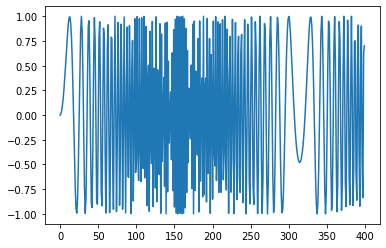

In [5]:
# plot it
plt.plot(series)
plt.show()

In [6]:
### build the dataset
# let's see if we can use T past values to predict the next value
T = 10
D = 1
X = []
Y = []
for t in range(len(series) - T):
  x = series[t:t+T]
  X.append(x)
  y = series[t+T]
  Y.append(y)

X = np.array(X).reshape(-1, T) # make it N x T
Y = np.array(Y)
N = len(X)
print("X.shape", X.shape, "Y.shape", Y.shape)

X.shape (390, 10) Y.shape (390,)


In [7]:
### try autoregressive linear model
i = Input(shape=(T,))
x = Dense(1)(i)
model = Model(i, x)
model.compile(
    loss = 'mse',
    optimizer=Adam(lr=0.01),
)

# train the RNN
r = model.fit(
    X[:-N//2], Y[:-N//2],
    epochs=80,
    validation_data=(X[-N//2:], Y[-N//2:]),
)

Train on 195 samples, validate on 195 samples
Epoch 1/80
195/195 [==============================] - 0s 601us/sample - loss: 1.0439 - val_loss: 1.2667
Epoch 2/80
195/195 [==============================] - 0s 90us/sample - loss: 0.9174 - val_loss: 1.1470
Epoch 3/80
195/195 [==============================] - 0s 85us/sample - loss: 0.8340 - val_loss: 1.0587
Epoch 4/80
195/195 [==============================] - 0s 84us/sample - loss: 0.7716 - val_loss: 0.9780
Epoch 5/80
195/195 [==============================] - 0s 77us/sample - loss: 0.7116 - val_loss: 0.9163
Epoch 6/80
195/195 [==============================] - 0s 77us/sample - loss: 0.6720 - val_loss: 0.8665
Epoch 7/80
195/195 [==============================] - 0s 71us/sample - loss: 0.6390 - val_loss: 0.8203
Epoch 8/80
195/195 [==============================] - 0s 74us/sample - loss: 0.6096 - val_loss: 0.7732
Epoch 9/80
195/195 [==============================] - 0s 86us/sample - loss: 0.5879 - val_loss: 0.7232
Epoch 10/80
195/195 [=====

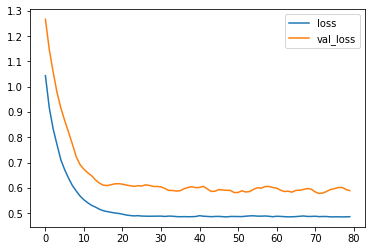

In [8]:
# Plot loss per iteration
import matplotlib.pyplot as plt
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()

(390, 1)


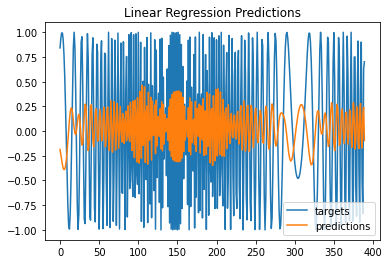

In [10]:
# One step forecast using true targets
# Note: even the one-step forecast fails badly
outputs = model.predict(X)
print(outputs.shape)
predictions = outputs[:, 0]

plt.plot(Y, label='targets')
plt.plot(predictions, label='predictions')
plt.title("Linear Regression Predictions")
plt.legend()
plt.show()

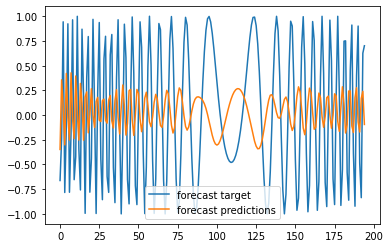

In [11]:
# This is the code we had before - it does the same thing
# one-step forecast using true targets

validation_target = Y[-N//2:]
validation_predictions = []

# index of first validation input
i = -N//2

while len(validation_predictions) < len(validation_target):
  p = model.predict(X[i].reshape(1, -1))[0, 0] # 1x1 array -> scalar
  i += 1

  # update the predictions list
  validation_predictions.append(p)

plt.plot(validation_target, label='forecast target')
plt.plot(validation_predictions, label='forecast predictions')
plt.legend()

In [17]:
### Now try RNN/LSTM model
X = X.reshape(-1, T, 1) # make it N x T x D

# make the RNN
i = Input(shape=(T, D))
x = LSTM(10)(i)
x = Dense(1)(x)
model = Model(i, x)
model.compile(
    loss='mse',
    optimizer=Adam(lr=0.05),
)

# train the RNN
r = model.fit(
    X[:-N//2], Y[:-N//2],
    batch_size = 32,
    epochs = 200,
    validation_data=(X[-N//2:], Y[-N//2:]),
)

Train on 195 samples, validate on 195 samples
Epoch 1/200
195/195 [==============================] - 1s 5ms/sample - loss: 0.5462 - val_loss: 0.5928
Epoch 2/200
195/195 [==============================] - 0s 291us/sample - loss: 0.5049 - val_loss: 0.6203
Epoch 3/200
195/195 [==============================] - 0s 261us/sample - loss: 0.4252 - val_loss: 0.4898
Epoch 4/200
195/195 [==============================] - 0s 256us/sample - loss: 0.3252 - val_loss: 0.5127
Epoch 5/200
195/195 [==============================] - 0s 273us/sample - loss: 0.2203 - val_loss: 0.3132
Epoch 6/200
195/195 [==============================] - 0s 246us/sample - loss: 0.1841 - val_loss: 0.2527
Epoch 7/200
195/195 [==============================] - 0s 255us/sample - loss: 0.1436 - val_loss: 0.2071
Epoch 8/200
195/195 [==============================] - 0s 258us/sample - loss: 0.1792 - val_loss: 0.2290
Epoch 9/200
195/195 [==============================] - 0s 250us/sample - loss: 0.1467 - val_loss: 0.2860
Epoch 10/20

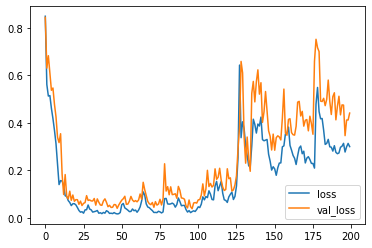

In [13]:
# plot the data
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()
plt.show()


(390, 1)


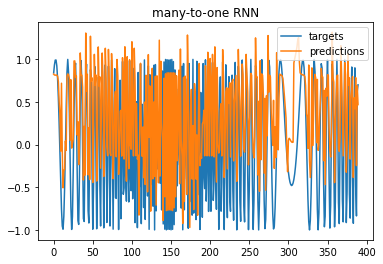

In [15]:
# One-step forecast using true targets
outputs = model.predict(X)
print(outputs.shape)
predictions = outputs[:, 0]

plt.plot(Y, label='targets')
plt.plot(predictions, label='predictions')
plt.title("many-to-one RNN")
plt.legend()
plt.show()

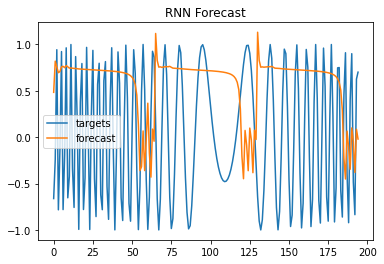

In [16]:
# Multi-step forecast
forecast = []
input_ = X[-N//2]
while len(forecast) < len(Y[-N//2:]):
  # Reshape the input_ to N x T x D
  f = model.predict(input_.reshape(1, T, 1))[0, 0]
  forecast.append(f)

  # make a new input with the latest forecast
  input_ = np.roll(input_, -1)
  input_[-1] = f


plt.plot(Y[-N//2:], label='targets')
plt.plot(forecast, label='forecast')
plt.title("RNN Forecast")
plt.legend()
plt.show()